trajectory forecasting with adaptive updating 

**Main Features**
- Brent Crude, WTI Crude, Dutch TTF Gas, Henry Hub Gas
- Equinor (EQNR.OL): Open, Close, High, Low, Volume, Market Cap
- OSEBX Index: Open, Close, High, Low, Volume
- VIX (volatility index)
- Dollar Index (DXY)

**Relevant Stocks**
- **Norway**: Aker BP (AKRBP), DNO (DNO), Vår Energi (VAR), Petroleum Geo-Services (PGS), BW Offshore (BWO), Frontline (FRO)
- **US/Global**: Exxon (XOM), Chevron (CVX), Shell (SHEL), BP (BP), TotalEnergies (TTE), ConocoPhillips (COP), Occidental (OXY)

**Stock Exchanges**
- S&P 500, NASDAQ, Dow Jones
- FTSE 100, DAX, CAC 40
- Nikkei 225, Hang Seng

**Commodity Prices**
- Gold (XAU), Silver (XAG)
- **Currencies**: USD/NOK, EUR/NOK, GBP/NOK, SEK/NOK, USD/EUR
- Coal (API2), Uranium (UX)
- Carbon Credits (EU ETS)

**Economic Indicators**
- **Interest Rates**: Norway (Norges Bank), US Fed Funds, ECB, BoE, BoJ, PBoC
- **Inflation**: Norway CPI, US CPI, EU HICP
- **Unemployment**: Norway, US, EU rates
- **Analyst Targets**: Equinor consensus price targets, EPS estimates


#### Fetch Dependencies

In [1]:
# Data fetching
import yfinance as yf

# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Optuna optimization
import optuna
from optuna.trial import TrialState

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Date and time handling
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

#### Collect Data

In [15]:
# CELL 1: COLLECT DATA

def collect_data(start_date="2021-01-01", end_date=None):
    """Collect stock data and return as DataFrame"""
    end_date = end_date or datetime.now().strftime('%Y-%m-%d')
    
    # Updated tickers based on research
    tickers = {
        # Main stock
        'EQNR.OL': 'equinor',
       
        # Energy commodities
        'BZ=F': 'brent_crude',
        'CL=F': 'wti_crude',
        'TTF=F': 'ttf_gas',
        'NG=F': 'henry_hub',
       
        # Norwegian energy stocks
        'AKRBP.OL': 'aker_bp',
        'DNO.OL': 'dno',
        'VAR.OL': 'var_energi',
        'PGS.OL': 'pgs',
        'BWO.OL': 'bw_offshore',
        'FRO.OL': 'frontline',
       
        # Global energy stocks
        'XOM': 'exxon',
        'CVX': 'chevron',
        'SHEL': 'shell',
        'BP': 'bp',
        'TTE': 'totalenergies',
        'COP': 'conocophillips',
        'OXY': 'occidental',
       
        # Indices
        'OSEBX.OL': 'osebx',
        '^GSPC': 'sp500',
        '^IXIC': 'nasdaq',
        '^DJI': 'dow_jones',
        '^FTSE': 'ftse100',
        '^GDAXI': 'dax',
        '^FCHI': 'cac40',
        '^N225': 'nikkei',
        '^HSI': 'hang_seng',
       
        # Volatility and Dollar
        '^VIX': 'vix',
        'DX-Y.NYB': 'dollar_index',
       
        # Commodities
        'GC=F': 'gold',
        'SI=F': 'silver',
       
        # Currencies
        'NOK=X': 'usd_nok',
        'EURNOK=X': 'eur_nok',
        'GBPNOK=X': 'gbp_nok',
        'SEKNOK=X': 'sek_nok',
        'EURUSD=X': 'eur_usd'
    }
    
    all_data = {}
    
    # Download each ticker separately to avoid alignment issues
    for ticker, name in tickers.items():
        try:
            print(f"Downloading {name}...")
            # Download individually
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            
            if len(data) > 0:
                # Only keep OHLC and Volume columns
                cols_to_keep = ['Open', 'High', 'Low', 'Close', 'Volume']
                data = data[[c for c in cols_to_keep if c in data.columns]]
                # Handle column renaming - columns might be strings or tuples
                new_cols = []
                for col in data.columns:
                    if isinstance(col, tuple):
                        col_name = col[0] if len(col) > 0 else str(col)
                    else:
                        col_name = str(col)
                    new_cols.append(f"{name}_{col_name.lower()}")
                data.columns = new_cols
                all_data[name] = data
                print(f"  ✓ {name}: {len(data)} rows")
            else:
                print(f"  ✗ No data received for {ticker}")
                
        except Exception as e:
            print(f"  ✗ Error fetching {ticker}: {e}")
    
    if not all_data:
        print("No data collected")
        return pd.DataFrame()
    
    # Combine using outer join to keep all dates
    df = pd.concat(all_data.values(), axis=1, join='outer')
    print(f"Combined data: {len(df)} rows, {len(df.columns)} columns")
    
    # Check initial NaN percentage
    nan_pct = df.isnull().sum().sum() / df.size * 100
    print(f"Initial NaN percentage: {nan_pct:.2f}%")
    
    # Keep only dates where Equinor traded (removes weekends/holidays)
    if 'equinor_close' in df.columns:
        before_filter = len(df)
        df = df[df['equinor_close'].notna()]
        print(f"Filtered to Equinor trading days: {before_filter} → {len(df)} rows")
    
    # Forward fill then backward fill to handle gaps
    df = df.ffill().bfill()
    
    # For any remaining NaNs at the beginning, drop those rows
    # This happens when some tickers start trading later than others
    first_valid_idx = df.first_valid_index()
    last_valid_idx = df.last_valid_index()
    if first_valid_idx and last_valid_idx:
        df = df.loc[first_valid_idx:last_valid_idx]
    
    # Final check for NaN percentage
    nan_count = df.isnull().sum().sum()
    if nan_count > 0:
        nan_pct_final = nan_count / df.size * 100
        print(f"Warning: {nan_count} NaN values remain ({nan_pct_final:.2f}%)")
        # Show which columns have NaNs
        nan_cols = df.columns[df.isnull().any()].tolist()
        if nan_cols:
            print(f"  Columns with NaNs: {nan_cols}")
    
    print(f"\nFinal data: {len(df)} rows, {len(df.columns)} columns")
    if len(df) > 0:
        print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
        nan_pct_final = df.isnull().sum().sum() / df.size * 100
        print(f"Final NaN percentage: {nan_pct_final:.2f}%")
    else:
        print("WARNING: No data remaining after processing")
    
    return df

In [16]:
# Run collection
data = collect_data(start_date="2001-01-01")

  ✓ equinor: 6256 rows
  ✓ brent_crude: 4506 rows
  ✓ wti_crude: 6199 rows
  ✓ ttf_gas: 1982 rows
  ✓ henry_hub: 6201 rows
  ✓ aker_bp: 4186 rows
  ✓ dno: 6256 rows
  ✓ var_energi: 895 rows
  ✓ pgs: 5227 rows
  ✓ bw_offshore: 4844 rows
  ✓ frontline: 6256 rows
  ✓ exxon: 6208 rows
  ✓ chevron: 6208 rows
  ✓ shell: 6208 rows
  ✓ bp: 6208 rows
  ✓ totalenergies: 6208 rows
  ✓ conocophillips: 6208 rows
  ✓ occidental: 6208 rows
  ✓ osebx: 3120 rows
  ✓ sp500: 6208 rows
  ✓ nasdaq: 6208 rows
  ✓ dow_jones: 6208 rows
  ✓ ftse100: 6236 rows
  ✓ dax: 6270 rows
  ✓ cac40: 6313 rows
  ✓ nikkei: 6046 rows
  ✓ hang_seng: 6083 rows
  ✓ vix: 6208 rows
  ✓ dollar_index: 6233 rows
  ✓ gold: 6195 rows
  ✓ silver: 6197 rows
  ✓ usd_nok: 6109 rows
  ✓ eur_nok: 6408 rows
  ✓ gbp_nok: 5666 rows
  ✓ sek_nok: 5198 rows
  ✓ eur_usd: 5650 rows
Combined data: 6441 rows, 180 columns
Initial NaN percentage: 12.53%
Filtered to Equinor trading days: 6441 → 6256 rows

Final data: 6256 rows, 180 columns
Date range: 

#### Rate of Change

In [19]:
# Add rate of change features
def add_rate_of_change(df):
    """Add rate of change features to existing dataframe"""
    
    # Key assets for rate of change analysis
    key_assets = ['equinor', 'brent_crude', 'wti_crude', 'usd_nok', 'vix']
    
    for asset in key_assets:
        close_col = f'{asset}_close'
        if close_col in df.columns:
            # First derivative (daily returns)
            df[f'{asset}_return'] = df[close_col].pct_change()
            
            # Second derivative (acceleration)
            df[f'{asset}_acceleration'] = df[f'{asset}_return'].diff()
            
            # Volatility momentum (20-day rolling vol change)
            rolling_vol = df[f'{asset}_return'].rolling(20).std()
            df[f'{asset}_vol_momentum'] = rolling_vol.pct_change()
    
    # Cross-asset correlation momentum (Equinor vs Brent)
    if 'equinor_return' in df.columns and 'brent_crude_return' in df.columns:
        rolling_corr = df['equinor_return'].rolling(20).corr(df['brent_crude_return'])
        df['eq_brent_corr_momentum'] = rolling_corr.diff()
    
    # Drop initial NaN rows created by calculations
    df = df.dropna()
    
    return df

# Apply to your data
data = add_rate_of_change(data)
print(f"After adding rate of change: {data.shape}")

After adding rate of change: (4548, 196)


#### Print Data

In [20]:
# CELL 2: PRINT HEAD OF DATA
print(f"Shape: {data.shape}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"Columns: {len(data.columns)}")
print(f"Remaining NaNs: {data.isnull().sum().sum()}")
print(f"NaN percentage: {data.isnull().sum().sum() / data.size * 100:.2f}%")
data.head()

Shape: (4548, 196)
Date range: 2007-08-01 to 2025-09-09
Columns: 196
Remaining NaNs: 0
NaN percentage: 0.00%


,equinor_open,equinor_high,equinor_low,equinor_close,equinor_volume,brent_crude_open,brent_crude_high,brent_crude_low,brent_crude_close,brent_crude_volume,...,wti_crude_return,wti_crude_acceleration,wti_crude_vol_momentum,usd_nok_return,usd_nok_acceleration,usd_nok_vol_momentum,vix_return,vix_acceleration,vix_vol_momentum,eq_brent_corr_momentum
Date,,,,,,,,,,,,,,,,,,,,,
2007-08-01,82.032837,82.632492,81.073389,82.032837,9960755.0,77.000000,77.059998,74.860001,75.349998,3930.0,...,-0.021481,-0.039442,0.091400,-0.001920,-0.002212,0.004430,0.006378,-0.120599,-0.001098,0.066992
2007-08-02,82.512563,82.632494,80.593666,81.792976,10785522.0,75.220001,76.209999,74.269997,75.760002,6180.0,...,0.004312,0.025793,-0.000461,-0.005170,-0.003250,0.030909,-0.103507,-0.109884,0.057004,0.033637
2007-08-03,81.912929,82.152791,80.713618,81.433205,11141460.0,75.389999,76.000000,74.529999,74.750000,4387.0,...,-0.017955,-0.022267,0.037209,-0.001260,0.003910,-0.003720,0.185674,0.289181,0.064666,-0.039792
2007-08-06,79.394384,80.353833,77.955211,78.075142,13812341.0,74.540001,74.599998,70.870003,71.169998,7201.0,...,-0.045310,-0.027355,0.216845,-0.000951,0.000310,-0.001964,-0.088235,-0.273909,0.039011,0.236648
2007-08-07,78.794728,79.274453,77.835280,78.075142,19840460.0,70.800003,72.010002,70.559998,71.800003,6775.0,...,0.004996,0.050306,-0.003878,0.004309,0.005260,0.001329,-0.060157,0.028078,-0.035674,0.004526


#### Save Matrix to CSV

In [21]:
# CELL 3: SAVE TO CSV
filepath = "data/equinor_data_8sept.csv"
data.to_csv(filepath)
print(f"Saved {len(data)} rows to {filepath}")

Saved 4548 rows to data/equinor_data_8sept.csv


### Add temporal awareness

In [22]:
# Read existing CSV
df = pd.read_csv('data/equinor_data_8sept.csv', index_col=0, parse_dates=True)

# Add temporal features
df['dow_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df['dow_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

df['dom_sin'] = np.sin(2 * np.pi * df.index.day / 30.436875)
df['dom_cos'] = np.cos(2 * np.pi * df.index.day / 30.436875)

df['doy_sin'] = np.sin(2 * np.pi * df.index.dayofyear / 365.25)
df['doy_cos'] = np.cos(2 * np.pi * df.index.dayofyear / 365.25)

df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

df['quarter_sin'] = np.sin(2 * np.pi * df.index.quarter / 4)
df['quarter_cos'] = np.cos(2 * np.pi * df.index.quarter / 4)

# Save enhanced CSV
df.to_csv('data/equinor_data_temporal.csv')
print(f"Added 10 temporal features. New shape: {df.shape}")

Added 10 temporal features. New shape: (4548, 206)


### Model

Using device: mps
DYNAMIC KANERVA MACHINE FOR EQUINOR FORECASTING

1. Loading data...
Features: 469 dimensions, 4469 samples
Train: 3128, Val: 670, Test: 671

2. Creating datasets...

3. Initializing Dynamic Kanerva Machine...
Model parameters: 272,508

4. Training...
Epoch   0 | Train Loss: 0.0067 (MSE: 0.0043, KL: 2.3271) | Val Loss: 0.0059 | Val Dir Acc: 60.8%
Epoch   5 | Train Loss: 0.0037 (MSE: 0.0013, KL: 2.3268) | Val Loss: 0.0051 | Val Dir Acc: 56.1%
Epoch  10 | Train Loss: 0.0033 (MSE: 0.0010, KL: 2.3267) | Val Loss: 0.0050 | Val Dir Acc: 54.7%
Epoch  15 | Train Loss: 0.0031 (MSE: 0.0008, KL: 2.3266) | Val Loss: 0.0056 | Val Dir Acc: 56.1%
Early stopping!

5. Testing...

Test Results:
  MSE Loss: 0.0056
  5-Day Direction Accuracy: 51.3%
  Day  1 - Correlation: -0.020, Direction: 49.0%
  Day  5 - Correlation: -0.059, Direction: 51.3%
  Day 10 - Correlation: -0.045, Direction: 54.3%
  Day 20 - Correlation: 0.027, Direction: 50.9%

6. Visualizing forecasts...


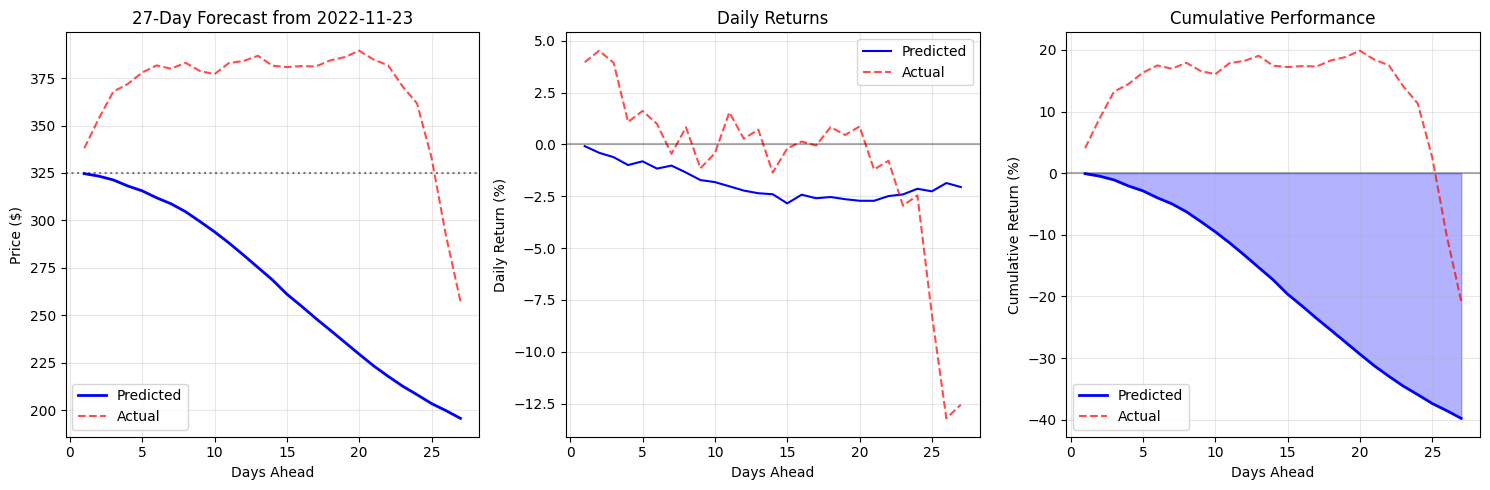


5-Day Return: Predicted=-2.92%, Actual=15.12%
Direction Correct: False


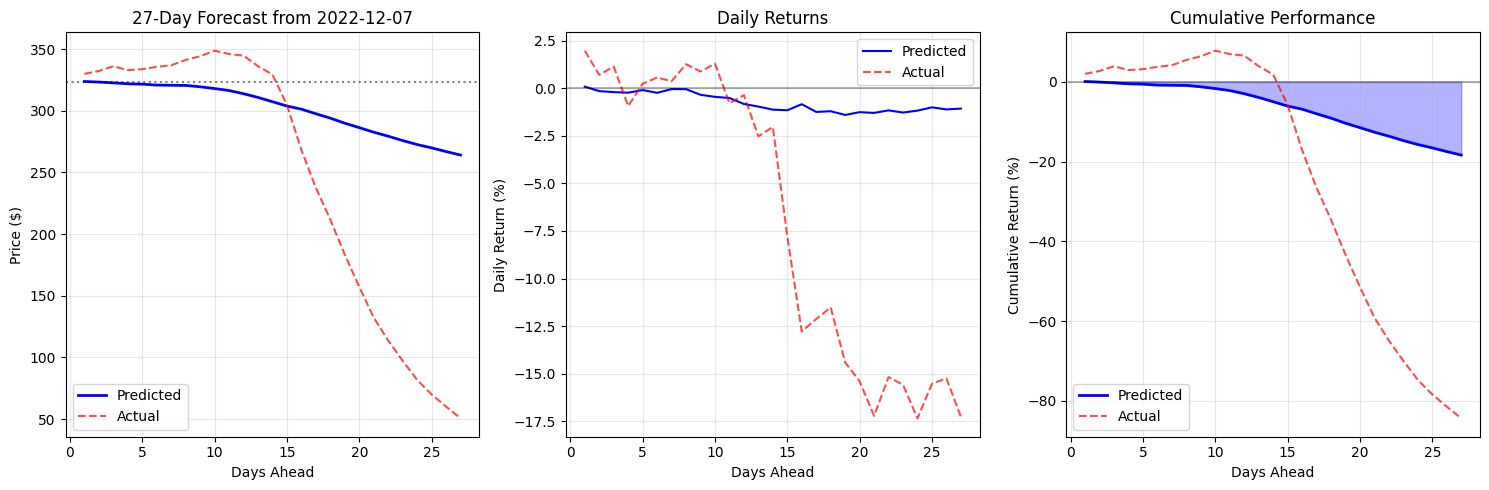


5-Day Return: Predicted=-0.59%, Actual=3.13%
Direction Correct: False


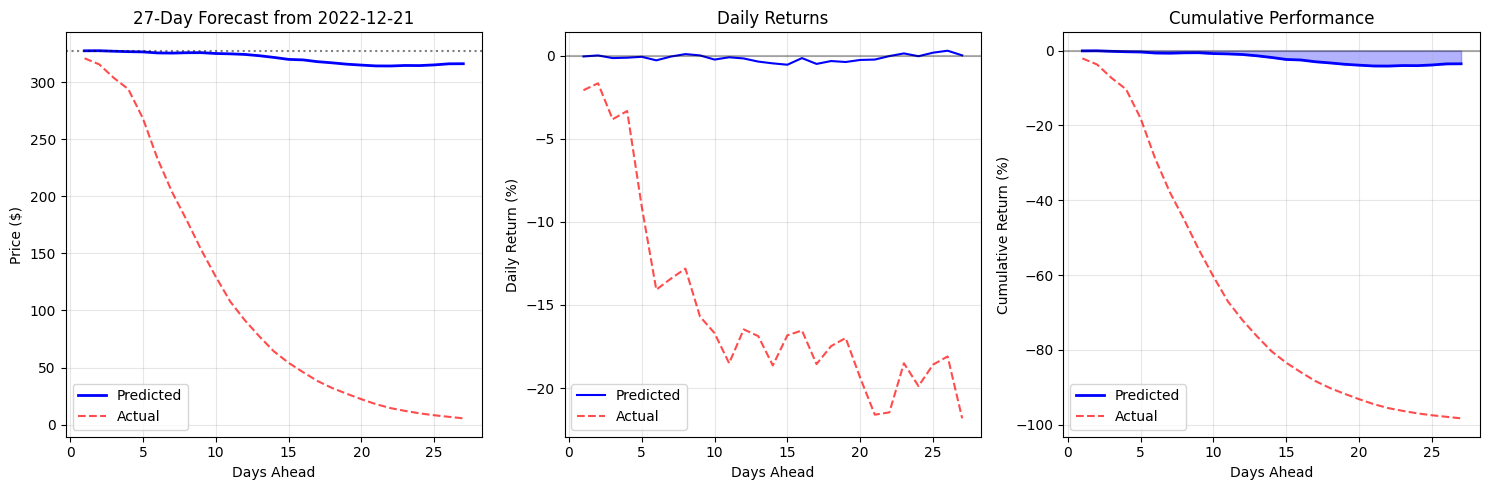


5-Day Return: Predicted=-0.34%, Actual=-19.95%
Direction Correct: True

7. Current forecast...

Training complete!


In [23]:
"""
Dynamic Kanerva Machine for Time Series Forecasting
Adapted for Equinor 30-day price trajectory prediction
Professor's implementation - minimal, robust, functional
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# Device configuration for M2 Mac
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# ============================================================================
# DATA PREPARATION
# ============================================================================

def prepare_features(filepath='data/equinor_data_8sept.csv'):
    """Load and prepare the 196 features from your existing setup"""
    data = pd.read_csv(filepath, index_col=0, parse_dates=True)
    features = []
    feature_names = []
    
    # Critical energy assets
    critical_assets = ['equinor', 'brent_crude', 'wti_crude', 'ttf_gas', 'henry_hub', 
                      'aker_bp', 'var_energi', 'dno', 'osebx']
    
    price_cols = [col for col in data.columns if 'close' in col.lower()]
    assets = list(set([col.replace('_close', '') for col in price_cols]))
    
    # Generate features for each asset
    for asset in assets:
        if f'{asset}_close' in data.columns:
            price = data[f'{asset}_close']
            
            # Returns at multiple horizons
            for period in [1, 2, 3, 5, 10, 20, 30]:
                ret = price.pct_change(period)
                features.append(ret)
                feature_names.append(f'{asset}_ret_{period}d')
            
            # Volatility
            ret_1d = price.pct_change()
            for period in [5, 10, 20]:
                vol = ret_1d.rolling(period).std()
                features.append(vol)
                feature_names.append(f'{asset}_vol_{period}d')
            
            # Price relative to MA
            for period in [10, 20, 50]:
                if len(price) >= period:
                    ma = price.rolling(period).mean()
                    rel_ma = (price - ma) / ma
                    features.append(rel_ma)
                    feature_names.append(f'{asset}_relma{period}')
    
    # Domain-specific features
    if 'brent_crude_close' in data.columns and 'ttf_gas_close' in data.columns:
        oil_gas_ratio = data['brent_crude_close'] / (data['ttf_gas_close'] + 1e-6)
        features.append(oil_gas_ratio)
        feature_names.append('oil_gas_ratio')
    
    X = pd.concat(features, axis=1)
    X.columns = feature_names[:X.shape[1]]
    
    # Target: Equinor log returns for proper compounding
    y = []
    for h in range(1, 31):  # 30 days
        fwd_ret = np.log(data['equinor_close'].shift(-h) / data['equinor_close'])
        y.append(fwd_ret)
    
    y = pd.concat(y, axis=1)
    y.columns = [f'day_{i}' for i in range(1, 31)]
    
    # Remove NaN rows
    valid_idx = ~(X.isna().any(axis=1) | y.isna().any(axis=1))
    X = X[valid_idx].fillna(0)
    y = y[valid_idx]
    
    print(f"Features: {X.shape[1]} dimensions, {len(X)} samples")
    return X, y, data['equinor_close'][valid_idx]

# ============================================================================
# KANERVA MEMORY MODULE
# ============================================================================

class KanervaMemory(nn.Module):
    """
    Dynamic Kanerva Machine Memory
    Stores episodes and retrieves based on cues with Bayesian updates
    """
    def __init__(self, code_size=64, memory_size=256, sparse_ratio=0.1):
        super().__init__()
        self.code_size = code_size
        self.memory_size = memory_size
        self.sparse_ratio = sparse_ratio
        
        # Memory parameters (learned)
        self.memory_keys = nn.Parameter(torch.randn(memory_size, code_size))
        self.memory_values = nn.Parameter(torch.randn(memory_size, code_size))
        
        # Temperature for attention
        self.temperature = nn.Parameter(torch.ones(1))
        
    def compute_similarity(self, query, keys):
        """Compute similarity between query and memory keys"""
        # Cosine similarity scaled by temperature
        query_norm = F.normalize(query, dim=-1)
        keys_norm = F.normalize(keys, dim=-1)
        similarity = torch.matmul(query_norm, keys_norm.T) / self.temperature
        return similarity
    
    def read(self, cue, return_weights=False):
        """
        Read from memory given a cue
        cue: [batch_size, cue_length, code_size] or [batch_size, code_size]
        """
        if len(cue.shape) == 3:
            # If cue is sequential, pool it
            cue = cue.mean(dim=1)  # [batch_size, code_size]
        
        # Compute attention weights (this is the posterior)
        similarity = self.compute_similarity(cue, self.memory_keys)
        weights = F.softmax(similarity, dim=-1)  # [batch_size, memory_size]
        
        # Apply sparsity
        if self.sparse_ratio < 1.0:
            k = int(self.memory_size * self.sparse_ratio)
            topk_vals, topk_idx = torch.topk(weights, k, dim=-1)
            sparse_weights = torch.zeros_like(weights)
            sparse_weights.scatter_(-1, topk_idx, topk_vals)
            sparse_weights = sparse_weights / sparse_weights.sum(dim=-1, keepdim=True)
            weights = sparse_weights
        
        # Read values
        values = torch.matmul(weights, self.memory_values)  # [batch_size, code_size]
        
        if return_weights:
            return values, weights
        return values
    
    def write(self, episodes):
        """
        Write episodes to memory (during training)
        This updates the memory parameters via backprop
        """
        # In practice, this happens through gradient descent
        # The memory learns what to store during training
        pass
    
    def compute_kl_divergence(self, posterior_weights):
        """KL divergence between posterior and uniform prior"""
        prior = torch.ones_like(posterior_weights) / self.memory_size
        kl = torch.sum(posterior_weights * torch.log(posterior_weights / prior + 1e-8), dim=-1)
        return kl.mean()

# ============================================================================
# TIME SERIES ENCODER
# ============================================================================

class TimeSeriesEncoder(nn.Module):
    """
    Encodes time series sequences into latent codes
    Uses 1D CNN for efficiency and pattern detection
    """
    def __init__(self, input_size=196, code_size=64, seq_length=30):
        super().__init__()
        
        # 1D Convolutional layers for temporal patterns
        self.conv1 = nn.Conv1d(input_size, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        
        # Pooling and projection
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.project = nn.Linear(32, code_size)
        
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        """
        x: [batch_size, seq_length, input_size]
        returns: [batch_size, seq_length, code_size] or [batch_size, code_size]
        """
        # Transpose for Conv1d
        x = x.transpose(1, 2)  # [batch, input_size, seq_length]
        
        # Convolutional encoding
        h = F.relu(self.conv1(x))
        h = self.dropout(h)
        h = F.relu(self.conv2(h))
        h = self.dropout(h)
        h = F.relu(self.conv3(h))
        
        # Global pooling to get single representation
        h = self.pool(h).squeeze(-1)  # [batch, 32]
        
        # Project to code size
        code = self.project(h)  # [batch, code_size]
        
        return code

# ============================================================================
# TRAJECTORY DECODER
# ============================================================================

class TrajectoryDecoder(nn.Module):
    """
    Decodes latent codes into future trajectories
    """
    def __init__(self, code_size=64, output_days=27):
        super().__init__()
        
        self.output_days = output_days
        
        # Decode to trajectory
        self.decoder = nn.Sequential(
            nn.Linear(code_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, output_days)
        )
        
    def forward(self, code):
        """
        code: [batch_size, code_size]
        returns: [batch_size, output_days] (predicted log returns)
        """
        return self.decoder(code)

# ============================================================================
# DYNAMIC KANERVA MACHINE
# ============================================================================

class DynamicKanervaMachine(nn.Module):
    """
    Complete Dynamic Kanerva Machine for time series forecasting
    """
    def __init__(self, input_size=196, code_size=64, memory_size=256, 
                 cue_days=3, predict_days=27):
        super().__init__()
        
        self.input_size = input_size
        self.code_size = code_size
        self.cue_days = cue_days
        self.predict_days = predict_days
        self.total_days = cue_days + predict_days
        
        # Components
        self.encoder = TimeSeriesEncoder(input_size, code_size, self.total_days)
        self.memory = KanervaMemory(code_size, memory_size)
        self.decoder = TrajectoryDecoder(code_size, predict_days)
        
        # For combining memory read and encoded cue
        self.combine = nn.Sequential(
            nn.Linear(code_size * 2, code_size),
            nn.ReLU()
        )
        
    def forward(self, x_cue, x_full=None, training=False):
        """
        x_cue: [batch, cue_days, input_size] - first few days
        x_full: [batch, total_days, input_size] - full episode (training only)
        """
        batch_size = x_cue.shape[0]
        
        # Encode the cue
        cue_code = self.encoder(x_cue)  # [batch, code_size]
        
        # Read from memory
        memory_read, weights = self.memory.read(cue_code, return_weights=True)
        
        # Combine cue encoding with memory read
        combined = torch.cat([cue_code, memory_read], dim=-1)
        z = self.combine(combined)  # [batch, code_size]
        
        # Decode to trajectory
        trajectory = self.decoder(z)  # [batch, predict_days]
        
        # Compute KL divergence for regularization
        kl_loss = self.memory.compute_kl_divergence(weights)
        
        return trajectory, kl_loss
    
    def predict(self, x_cue):
        """Prediction mode - no KL loss needed"""
        self.eval()
        with torch.no_grad():
            trajectory, _ = self.forward(x_cue, training=False)
        return trajectory

# ============================================================================
# DATASET CLASS
# ============================================================================

class TrajectoryDataset(Dataset):
    """Dataset for trajectory prediction"""
    def __init__(self, X, y, cue_days=3, predict_days=27, scaler=None):
        self.cue_days = cue_days
        self.predict_days = predict_days
        self.total_days = cue_days + predict_days
        
        # Fit or use provided scaler
        if scaler is None:
            self.scaler = StandardScaler()
            self.X_scaled = self.scaler.fit_transform(X)
        else:
            self.scaler = scaler
            self.X_scaled = self.scaler.transform(X)
        
        # Create episodes
        self.episodes = []
        self.targets = []
        
        for i in range(len(X) - self.total_days):
            # Get features for the episode
            episode_features = self.X_scaled[i:i+self.total_days]
            # Get target returns (days 4-30)
            target_returns = y.iloc[i+self.cue_days, :self.predict_days].values
            
            self.episodes.append(episode_features)
            self.targets.append(target_returns)
        
        self.episodes = np.array(self.episodes)
        self.targets = np.array(self.targets)
        
    def __len__(self):
        return len(self.episodes)
    
    def __getitem__(self, idx):
        episode = self.episodes[idx]
        target = self.targets[idx]
        
        # Split into cue and full episode
        cue = episode[:self.cue_days]
        
        return (torch.FloatTensor(cue), 
                torch.FloatTensor(episode),
                torch.FloatTensor(target))

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, dataloader, optimizer, beta=0.001):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_mse = 0
    total_kl = 0
    
    for cue, full_episode, target in dataloader:
        cue = cue.to(device)
        target = target.to(device)
        
        # Forward pass
        pred_trajectory, kl_loss = model(cue, full_episode, training=True)
        
        # Losses
        mse_loss = F.mse_loss(pred_trajectory, target)
        loss = mse_loss + beta * kl_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        total_mse += mse_loss.item()
        total_kl += kl_loss.item()
    
    return total_loss / len(dataloader), total_mse / len(dataloader), total_kl / len(dataloader)

def evaluate(model, dataloader):
    """Evaluate model"""
    model.eval()
    total_mse = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for cue, _, target in dataloader:
            cue = cue.to(device)
            target = target.to(device)
            
            pred = model.predict(cue)
            mse = F.mse_loss(pred, target)
            
            total_mse += mse.item()
            predictions.append(pred.cpu().numpy())
            actuals.append(target.cpu().numpy())
    
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    
    # Calculate directional accuracy for day 5
    if predictions.shape[1] >= 5:
        pred_5d = predictions[:, 4]
        actual_5d = actuals[:, 4]
        direction_acc = np.mean(np.sign(pred_5d) == np.sign(actual_5d))
    else:
        direction_acc = 0
    
    return total_mse / len(dataloader), direction_acc, predictions, actuals

# ============================================================================
# VISUALIZATION
# ============================================================================

def plot_forecast(model, X_test, y_test, prices_test, idx=0):
    """Visualize a forecast"""
    model.eval()
    
    # Prepare input
    dataset = TrajectoryDataset(X_test, y_test, model.cue_days, model.predict_days)
    cue, _, actual = dataset[idx]
    
    with torch.no_grad():
        cue_batch = cue.unsqueeze(0).to(device)
        pred_trajectory = model.predict(cue_batch).cpu().numpy()[0]
    
    actual_trajectory = actual.numpy()
    
    # Convert log returns to prices
    current_price = prices_test.iloc[idx + model.cue_days]
    pred_prices = current_price * np.exp(np.cumsum(pred_trajectory))
    actual_prices = current_price * np.exp(np.cumsum(actual_trajectory))
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Trajectory comparison
    ax = axes[0]
    days = np.arange(1, model.predict_days + 1)
    ax.plot(days, pred_prices, 'b-', label='Predicted', linewidth=2)
    ax.plot(days, actual_prices, 'r--', label='Actual', alpha=0.7)
    ax.axhline(current_price, color='black', linestyle=':', alpha=0.5)
    ax.set_xlabel('Days Ahead')
    ax.set_ylabel('Price ($)')
    ax.set_title(f'27-Day Forecast from {X_test.index[idx].date()}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Returns comparison
    ax = axes[1]
    ax.plot(days, pred_trajectory * 100, 'b-', label='Predicted')
    ax.plot(days, actual_trajectory * 100, 'r--', label='Actual', alpha=0.7)
    ax.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax.set_xlabel('Days Ahead')
    ax.set_ylabel('Daily Return (%)')
    ax.set_title('Daily Returns')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Cumulative returns
    ax = axes[2]
    cum_pred = (np.exp(np.cumsum(pred_trajectory)) - 1) * 100
    cum_actual = (np.exp(np.cumsum(actual_trajectory)) - 1) * 100
    ax.plot(days, cum_pred, 'b-', label='Predicted', linewidth=2)
    ax.plot(days, cum_actual, 'r--', label='Actual', alpha=0.7)
    ax.axhline(0, color='black', linestyle='-', alpha=0.3)
    ax.fill_between(days, cum_pred, 0, alpha=0.3, color='blue')
    ax.set_xlabel('Days Ahead')
    ax.set_ylabel('Cumulative Return (%)')
    ax.set_title('Cumulative Performance')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    pred_5d = np.sum(pred_trajectory[:5])
    actual_5d = np.sum(actual_trajectory[:5])
    print(f"\n5-Day Return: Predicted={pred_5d*100:.2f}%, Actual={actual_5d*100:.2f}%")
    print(f"Direction Correct: {(pred_5d > 0) == (actual_5d > 0)}")

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

def main():
    print("="*60)
    print("DYNAMIC KANERVA MACHINE FOR EQUINOR FORECASTING")
    print("="*60)
    
    # Load data
    print("\n1. Loading data...")
    X, y, prices = prepare_features()
    
    # Split data (70/15/15)
    train_size = int(0.7 * len(X))
    val_size = int(0.85 * len(X))
    
    X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
    X_val, y_val = X.iloc[train_size:val_size], y.iloc[train_size:val_size]
    X_test, y_test = X.iloc[val_size:], y.iloc[val_size:]
    prices_test = prices.iloc[val_size:]
    
    print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    
    # Create datasets
    print("\n2. Creating datasets...")
    train_dataset = TrajectoryDataset(X_train, y_train, cue_days=3, predict_days=27)
    val_dataset = TrajectoryDataset(X_val, y_val, cue_days=3, predict_days=27, 
                                   scaler=train_dataset.scaler)
    test_dataset = TrajectoryDataset(X_test, y_test, cue_days=3, predict_days=27,
                                    scaler=train_dataset.scaler)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize model
    print("\n3. Initializing Dynamic Kanerva Machine...")
    model = DynamicKanervaMachine(
        input_size=X.shape[1],
        code_size=64,
        memory_size=256,
        cue_days=3,
        predict_days=27
    ).to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Training loop
    print("\n4. Training...")
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(50):
        # Train
        train_loss, train_mse, train_kl = train_epoch(model, train_loader, optimizer, beta=0.001)
        
        # Validate
        val_loss, val_dir_acc, _, _ = evaluate(model, val_loader)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_kanerva_model.pth')
        else:
            patience_counter += 1
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} (MSE: {train_mse:.4f}, KL: {train_kl:.4f}) | "
                  f"Val Loss: {val_loss:.4f} | Val Dir Acc: {val_dir_acc:.1%}")
        
        if patience_counter >= 10:
            print("Early stopping!")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_kanerva_model.pth'))
    
    # Test evaluation
    print("\n5. Testing...")
    test_loss, test_dir_acc, test_preds, test_actuals = evaluate(model, test_loader)
    
    print(f"\nTest Results:")
    print(f"  MSE Loss: {test_loss:.4f}")
    print(f"  5-Day Direction Accuracy: {test_dir_acc:.1%}")
    
    # Calculate additional metrics
    for horizon in [1, 5, 10, 20]:
        if horizon <= test_preds.shape[1]:
            pred_h = test_preds[:, horizon-1]
            actual_h = test_actuals[:, horizon-1]
            corr = np.corrcoef(pred_h, actual_h)[0, 1]
            dir_acc = np.mean(np.sign(pred_h) == np.sign(actual_h))
            print(f"  Day {horizon:2d} - Correlation: {corr:.3f}, Direction: {dir_acc:.1%}")
    
    # Visualize some forecasts
    print("\n6. Visualizing forecasts...")
    for i in range(min(3, len(X_test) - 30)):
        plot_forecast(model, X_test, y_test, prices_test, idx=i*10)
    
    # Generate current forecast
    print("\n7. Current forecast...")
    current_features = X.iloc[-30:]  # Last 30 days
    current_dataset = TrajectoryDataset(
        current_features, 
        pd.DataFrame(np.zeros((30, 30))),  # Dummy targets
        cue_days=3, 
        predict_days=27,
        scaler=train_dataset.scaler
    )
    
    if len(current_dataset) > 0:
        cue, _, _ = current_dataset[-1]
        with torch.no_grad():
            pred = model.predict(cue.unsqueeze(0).to(device)).cpu().numpy()[0]
        
        current_price = prices.iloc[-1]
        pred_prices = current_price * np.exp(np.cumsum(pred))
        
        print(f"Current Price: ${current_price:.2f}")
        print(f"Predicted Prices:")
        for day in [1, 5, 10, 20, 27]:
            if day <= len(pred_prices):
                ret = (pred_prices[day-1] / current_price - 1) * 100
                print(f"  Day {day:2d}: ${pred_prices[day-1]:.2f} ({ret:+.1f}%)")
    
    print("\n" + "="*60)
    print("Training complete!")
    
    return model, test_preds, test_actuals

if __name__ == "__main__":
    model, predictions, actuals = main()